In [2]:
import simpy
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

% matplotlib inline

In [27]:
RANDOM_SEED = 1
INITIAL_MEMBER = 20
NUM_MACHINES = 12  # Number of machines in the carwash
SIM_TIME = 720     # Simulation time in minutes
COMING_MEAN = 8
EATING_MEAN = 20
EATING_SIGMA = 1
SERVING_MEAN = 8
SERVING_SIGMA = 0.1
NUM_CLERK = 3

class ShopProcess():
    
    def __init__(self, num_chairs, num_clerk, env, serve_time, eat_time, coming_time, use_exp=True, eat_time_std=1, serve_time_std = 0.5):
        self.env = env
        self.chairs = simpy.Resource(env, num_chairs)
        
        self.shop_member = simpy.Resource(env, num_clerk)
        
        self.num_clerk = num_clerk
        
        self.increase_chair = (num_chairs - 8)
        
        self.increase_member = (num_clerk - 2)
        
        self.improve_time = (10 - serve_time)
    
        self.coming_time = coming_time
        self.serve_time = serve_time
        self.eat_time = eat_time
        
        self.came_guest = 0
        self.loose_guest = 0
        
        self.serving_guest = 0
        self.use_exp = use_exp
        
        self.eat_time_std = eat_time_std
        self.serve_time_std = serve_time_std
        
        self.data = {"chair_time":[],
                     "chair_user_num":[], 
                     "chair_queue":[], 
                     "cook_time":[],
                     "cook_user_num":[], 
                     "cook_queue":[], 
                     "wait_enter":[], 
                     "wait_for_clerk":[],
                     "guest_id":[],
                     "is_enter":[]}
        
    
    @property
    def time_to_come(self):
        return random.expovariate(1./self.coming_time)
    
    @property
    def time_to_serve(self):
        if self.use_exp:
            return random.expovariate(1./self.serve_time)
        else:
            return random.normalvariate(self.serve_time, self.serve_time_std)
        
    @property
    def time_to_eat(self):
        if self.use_exp:
            return random.expovariate(1./self.eat_time)
        else:
            return random.normalvariate(self.eat_time, self.eat_time_std)
        
    def monitor(self, chair=True, is_nan=False):
        if chair:
            self.data["chair_time"].append(self.chairs._env.now)
            self.data["chair_user_num"].append(self.chairs.count)
            self.data["chair_queue"].append(len(self.chairs.queue))
        else:
            if is_nan:
                self.data["cook_time"].append(np.nan)
                self.data["cook_user_num"].append(np.nan)
                self.data["cook_queue"].append(np.nan)
            else:
                self.data["cook_time"].append(self.shop_member._env.now)
                self.data["cook_user_num"].append(self.shop_member.count)
                self.data["cook_queue"].append(len(self.shop_member.queue))
                
    def costomer_action(self, name, patience=np.inf):
        arrive = self.env.now
#         print('%s arrives at the la-men at %.2f.' % (name, self.env.now))
        with self.chairs.request() as request:
            self.monitor()
            yield request

            wait = self.env.now - arrive
            
            is_enter = wait < patience
            self.data["wait_enter"].append(wait)
            self.data["is_enter"].append(is_enter)

            if is_enter:
                self.came_guest += 1
#                 print('%s enters the la-men at %.2f.' % (name, self.env.now))
                enter = self.env.now
                with self.shop_member.request() as request:
                    self.monitor(chair=False)
                    yield request
                    
                    wait_for_clerk = self.env.now - enter
                    self.data["wait_for_clerk"].append(wait_for_clerk)
                    yield self.env.timeout(self.time_to_serve)

#                 print('%s starts eating la-men at %.2f.' % (name, self.env.now))

                yield self.env.timeout(self.time_to_eat)
#                 print('%s leaves the la-men at %.2f.' % (name, self.env.now))

            else:
                self.monitor(chair=False, is_nan=True)
                self.data["wait_for_clerk"].append(np.nan)
                self.loose_guest += 1


#                 print('%s finish eating la-men at %.2f.' % (name, self.env.now))
    
    @property
    def skill_cost(self):
        return 0.5+self.improve_time*0.5
               
    def revenue(self, chair_cost=30000, revenue_per_guest=8, worker_cost=2000):
        fix_cost = chair_cost*self.increase_chair
        payment_cost = worker_cost*self.increase_member*12
        increase_cost = self.skill_cost * self.improve_time * 12 * 365 * self.num_clerk
        
        lose_revenue = self.loose_guest * revenue_per_guest
        return {"get":self.came_guest * revenue_per_guest * 2*365- fix_cost - payment_cost - increase_cost, "lose":lose_revenue}
                

def setup(env, shop, ini_num, max_num=4):
    """Create a carwash, a number of initial cars and keep creating cars
    approx. every ``t_inter`` minutes."""
    # Create the carwash

    # Create 4 initial cars
    for i in range(ini_num):
        patience = np.inf
        env.process(shop.costomer_action('Guest %d' % i, patience=patience))
        shop.data["guest_id"].append(i)

    # Create more cars while the simulation is running
    while True:
        yield env.timeout(shop.time_to_come)
        patience = np.inf
        shop.data["guest_id"].append(i)
        env.process(shop.costomer_action('Guest %d' % (i), patience))
        i += 1

            


EAT_EXP = True
SERVE_EXP = True
USE_EXP = False

# Setup and start the simulation
random.seed()  # This helps reproducing the results

# Create an environment and start the setup process

sim_num = 1

all_data = {
    "pattern":[],
    "sim_num":[],
    "mean_wait_time":[],
    "wait_times":[],
    "wait_prob":[],
    "no_wait_times":[],
    "mean_sys_num":[],
    "get_revenue":[],
    "lose_revenue":[]
}   

def sim_many_time(choices=None, num_machine=12, coming_mean=3, ini_num=15, serving_mean=8, eating_mean=20, num_clerk=3, sim_num=100, sim_time=180):
    whole_queue = None
    whole_wait_dist = None

    print("--------------parmetor------------")
    print("num_machine:",num_machine)
    print("coming_mean:",coming_mean)
    print("serving_mean:",serving_mean)
    print("num_clerk:",num_clerk)
    print("eating_mean:",eating_mean)
    
    for sm in tqdm(range(sim_num)):
        env = simpy.Environment()

        shop = ShopProcess(num_machine, num_clerk, env, serving_mean, eating_mean, coming_mean, use_exp=USE_EXP)
        env.process(setup(env, shop, ini_num=ini_num, max_num=2))

        # Execute!
        env.run(until=sim_time)

        minimum_len = min(map(len, shop.data.values()))
        for key in shop.data.keys():
            shop.data[key] = shop.data[key][:minimum_len]
        monitored_data = pd.DataFrame(shop.data)
        mean_wait_time = monitored_data.wait_enter.mean()
        act_wait = monitored_data.wait_enter>0
        wait_num = act_wait.sum()
        wait_prob = act_wait.mean()
        queue = monitored_data.chair_user_num + monitored_data.chair_queue.values
        wait_dist = monitored_data.wait_enter.values
        if whole_wait_dist is None:
            whole_wait_dist = wait_dist
        else:
            min_length = min(map(len, [wait_dist, whole_wait_dist]))
            whole_wait_dist = whole_wait_dist[:min_length]
            whole_wait_dist += wait_dist[:min_length]          
        if whole_queue is None:
            whole_queue = queue.values
        else:
            min_length = min(map(len, [queue, whole_queue]))
            whole_queue = whole_queue[:min_length]
            whole_queue += queue.values[:min_length]
        mean_queue = queue.mean()
#         print("mean wait time:", mean_wait_time)
#         print("wait times:", wait_num, "| no wait times:", len(monitored_data)-wait_num)
#         print("wait prob:", wait_prob, "| no wait prob:", 1-wait_prob)
        all_data["pattern"].append(1)
        all_data["sim_num"].append(sm)
        all_data["mean_wait_time"].append(mean_wait_time)
        all_data["wait_times"].append(wait_num)
        all_data["wait_prob"].append(wait_prob)
        all_data["no_wait_times"].append(len(monitored_data)-wait_num)
        all_data["mean_sys_num"].append(mean_queue)
        revenue = shop.revenue()
        all_data["get_revenue"].append(revenue["get"])
        all_data["lose_revenue"].append(revenue["lose"])
    whole_queue = whole_queue/sim_num
    whole_wait_dist = whole_wait_dist/sim_num
    return all_data, whole_queue, whole_wait_dist
            
def sim_one_time(coming_mean=COMING_MEAN, 
                 initial_number=INITIAL_MEMBER, 
                 num_clerk=NUM_CLERK, 
                 simtime=SIM_TIME, 
                 chair_num=NUM_MACHINES,
                 serve_mean=SERVING_MEAN):
    env = simpy.Environment()

    shop = ShopProcess(chair_num, num_clerk, env, serve_mean, EATING_MEAN, coming_mean, use_exp=USE_EXP)
    env.process(setup(env, shop, initial_number, max_num=1))

    # Execute!
    env.run(until=simtime)

    minimum_len = min(map(len,shop.data.values()))
#     print(shop.data)
#     print("minimum length:", minimum_len)
    for key in shop.data.keys():
        shop.data[key] = shop.data[key][:minimum_len]
    monitored_data = pd.DataFrame(shop.data)
    mean_wait_time = monitored_data.wait_enter.mean()
    act_wait = monitored_data.wait_enter>0
    wait_num = act_wait.sum()
    wait_prob = act_wait.mean()
    print("mean wait time:", mean_wait_time)
    print("wait times:", wait_num, "| no wait times:", len(monitored_data)-wait_num)
    print("wait prob:", wait_prob, "| no wait prob:", 1-wait_prob)
    
    return monitored_data

# all_data = pd.DataFrame(all_data)
# for_visualize = all_data.groupby("mn").agg(["mean", "std"])

# plt.plot(for_visualize["mn"], for_visualize["mean_wait_time"]["mean"])
def draw_result(data, col, coming_mean, initial_number, num_clerk, chair_num, is_devide=True):
    plt.figure()
    title = "{}_by_time_COME_{}_INI_{}_NC_{}_CN_{}".format(col, coming_mean, initial_number, num_clerk, chair_num)
    if is_devide:
        leave_data = data[data.is_enter==False]
        enter_data = data[data.is_enter==True]

        plt.scatter(leave_data["chair_time"], leave_data[col], color="skyblue", alpha=0.8, marker="d")
        plt.scatter(enter_data["chair_time"], enter_data[col], color="orange", alpha=0.5)

    else:
        plt.scatter(data["chair_time"], data[col], color="skyblue", alpha=0.5)
    plt.title(title)
#     plt.savefig(title+".png")
    
    
def plot_hist(array, name):
    plt.figure()
    title = "histgram {}".format(name)
    bin_num = np.sqrt(len(array))
    bins = np.linspace(min(array), max(array), bin_num)
    plt.hist(array, bins=bins)
    plt.title(title)
    plt.xlim(0,30)
    plt.ylim(0,50)
    
#     plt.savefig(title)

### シミュレーション時間3時間

--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 2
eating_mean: 20


A Jupyter Widget

C:\Users\Mintei Kou\Anaconda3\lib\site-packages\ipykernel_launcher.py:296: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 4
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 5
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 6
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 7
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 8
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 9
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 10
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 11
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget

C:\Users\Mintei Kou\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


--------------parmetor------------
num_machine: 12
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 13
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 14
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 15
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 16
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 9
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 8
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 7
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 6
num_clerk: 3
eating_mean: 20


A Jupyter Widget


--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 5
num_clerk: 3
eating_mean: 20


A Jupyter Widget

C:\Users\Mintei Kou\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


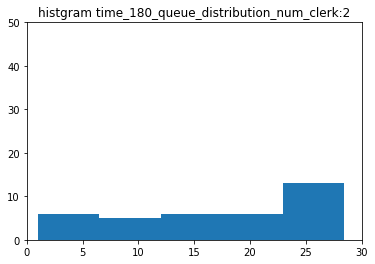

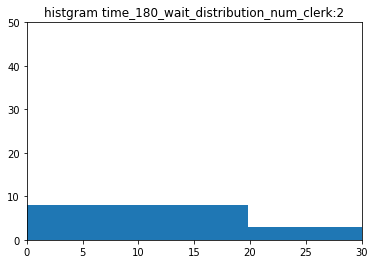

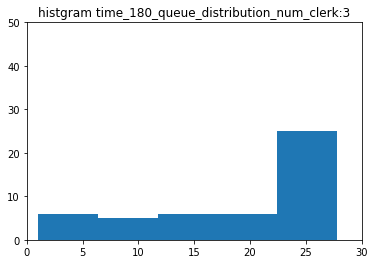

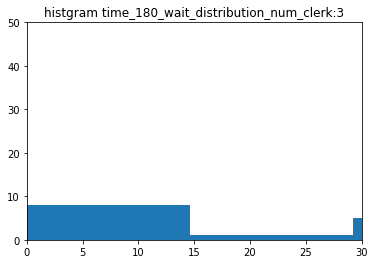

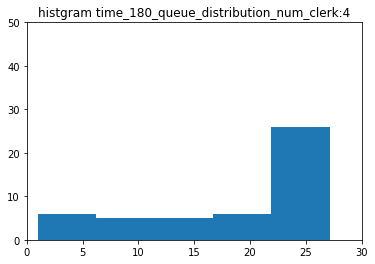

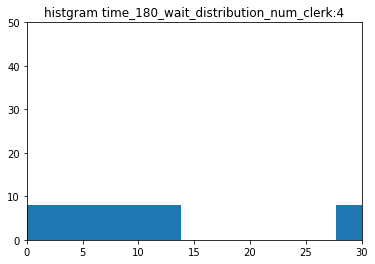

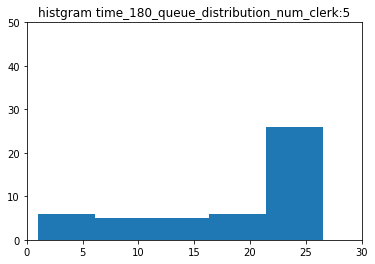

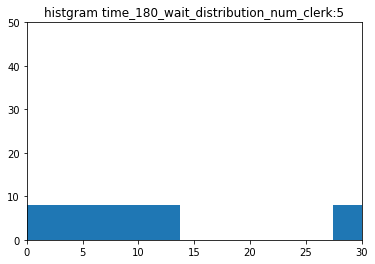

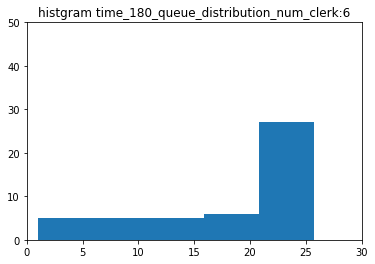

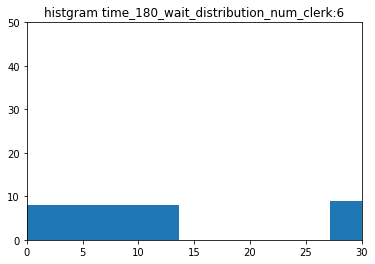

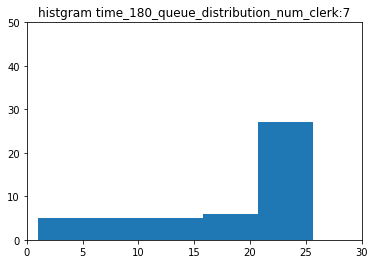

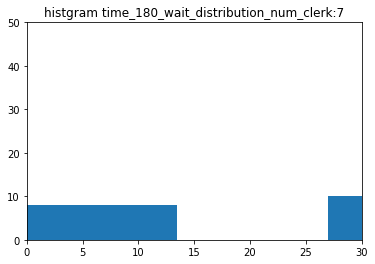

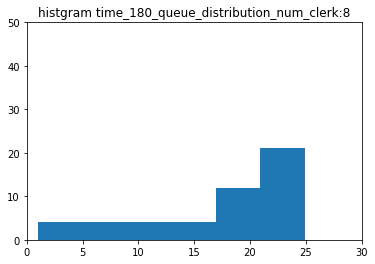

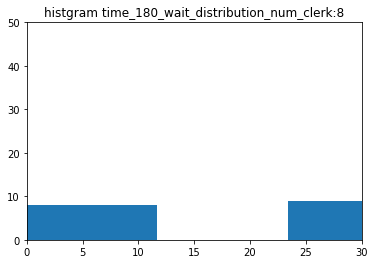

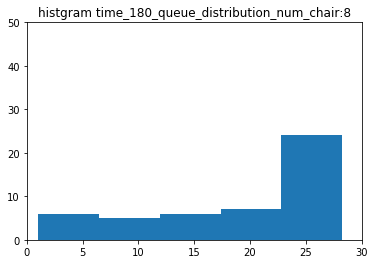

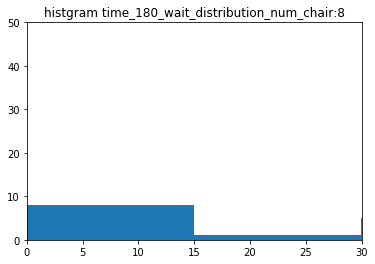

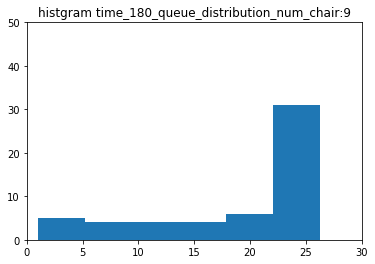

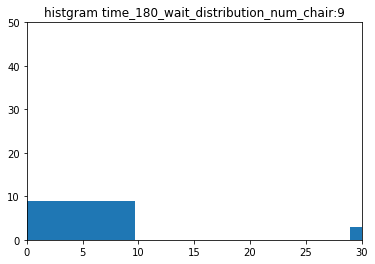

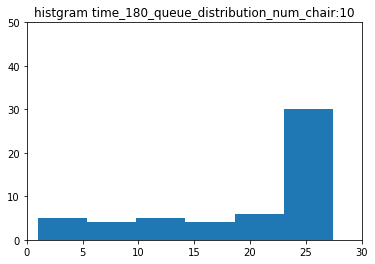

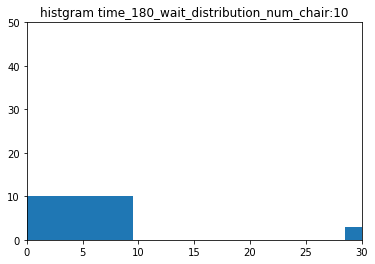

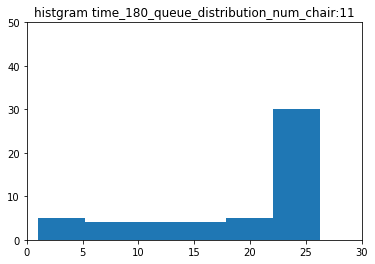

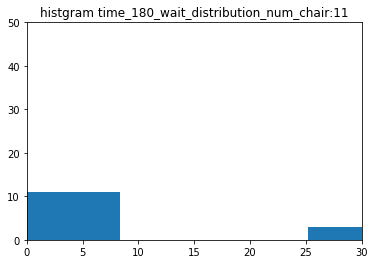

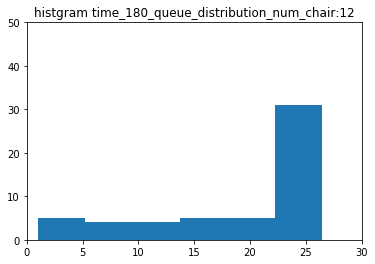

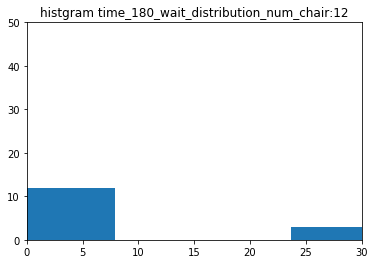

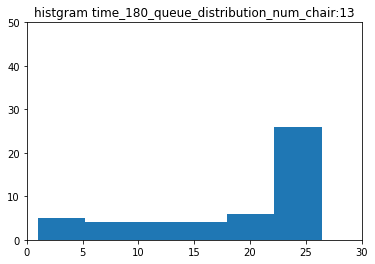

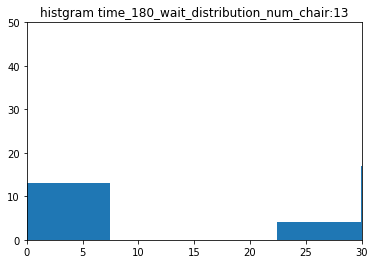

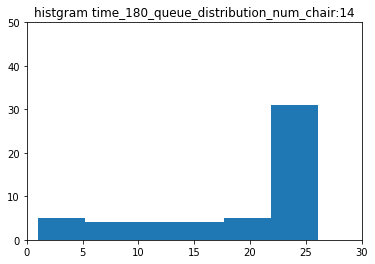

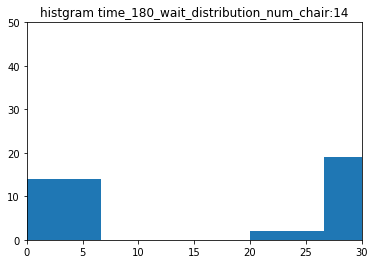

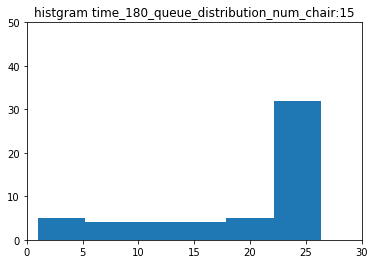

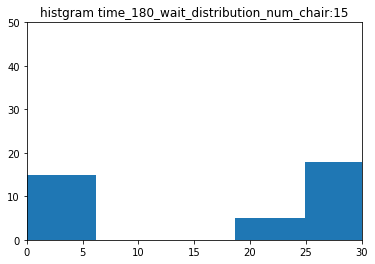

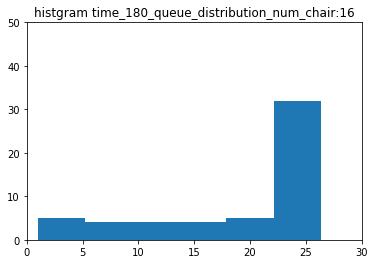

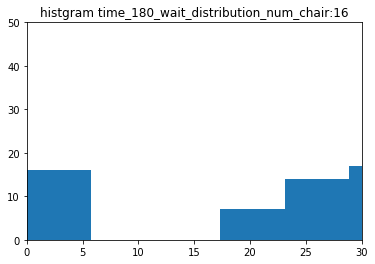

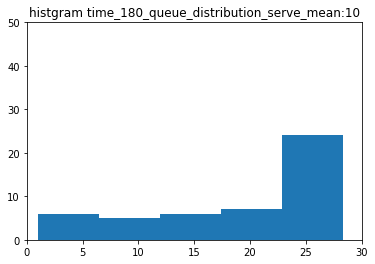

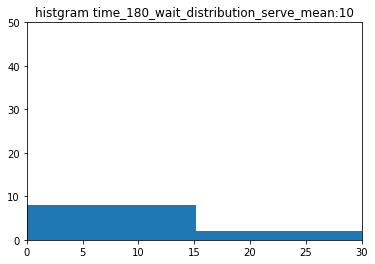

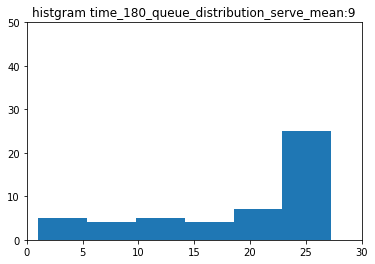

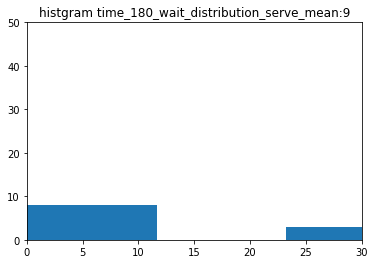

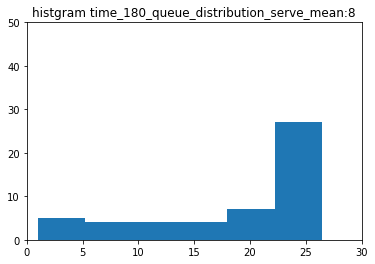

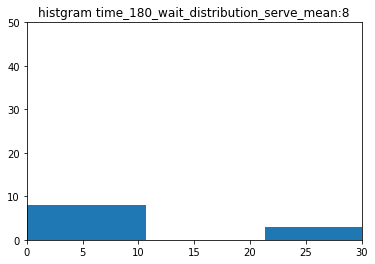

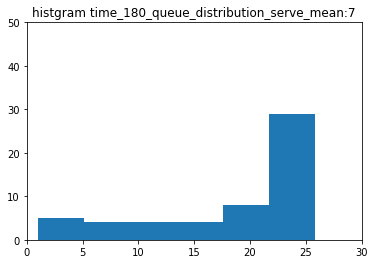

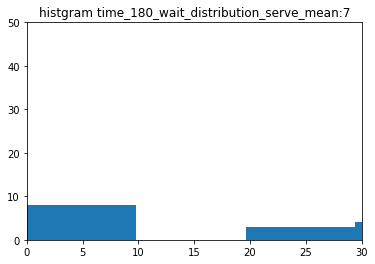

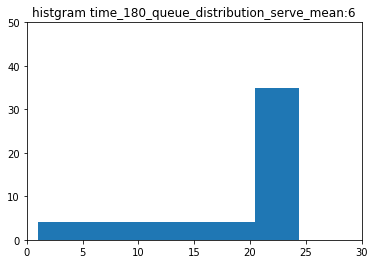

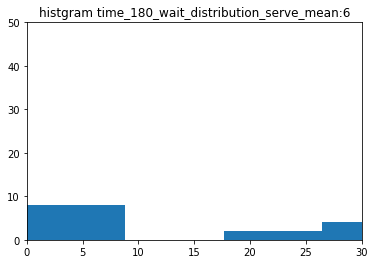

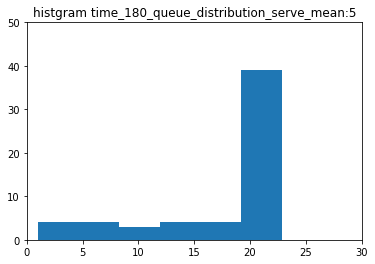

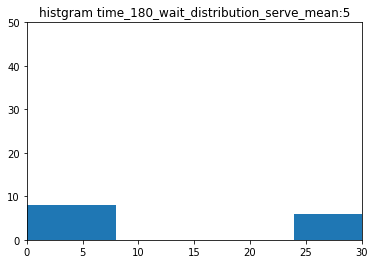

In [25]:
# param = {
#     "num_clerk":[1,2,3,4,5,6,7],
#     "num_chair":[8,9,10,11,12,13,14,15,16],
#     "serving_mean":[10,9,8,7,6,5]
# }

param = {
    "num_clerk":[2,3,4,5,6,7,8],
    "num_chair":[8,9,10,11,12,13,14,15,16],
    "serving_mean":[10,9,8,7,6,5]
}

sim_time=180
sim_num = 100
sim_result = None

revenues = {"num_clerk":{"mean":[],"std":[]},
            "num_chair":{"mean":[],"std":[]},
            "serving_mean":{"mean":[],"std":[]},
           }

lose_revenues = {"num_clerk":{"mean":[],"std":[]},
            "num_chair":{"mean":[],"std":[]},
            "serving_mean":{"mean":[],"std":[]},
           }

for nc in param["num_clerk"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_clerk=nc, num_machine=8, serving_mean=10, sim_time=sim_time, sim_num=sim_num)
    monitored_data = pd.DataFrame(monitored_data)
    monitored_data["pattern"] = pd.Series(["num_clerk"]*len(monitored_data))
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_num_clerk:{}".format(sim_time, nc))
    plot_hist(wait_dist, name="time_{}_wait_distribution_num_clerk:{}".format(sim_time, nc))
    for_visualize.columns = [col[0]+"_"+col[1] for col in for_visualize.columns]
    if sim_result is None:
        sim_result = for_visualize
    else:
        sim_result = pd.concat([sim_result, for_visualize])

for nc in param["num_chair"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_machine=nc, serving_mean=10, sim_time=sim_time, sim_num=sim_num)
    monitored_data = pd.DataFrame(monitored_data)
    monitored_data["pattern"] = pd.Series(["num_chair"]*len(monitored_data))
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_num_chair:{}".format(sim_time, nc))
    plot_hist(wait_dist, name="time_{}_wait_distribution_num_chair:{}".format(sim_time, nc))
    for_visualize.columns = [col[0]+"_"+col[1] for col in for_visualize.columns]
    if sim_result is None:
        sim_result = for_visualize
    else:
        sim_result = pd.concat([sim_result, for_visualize])
    
for serve_m in param["serving_mean"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_machine=8, serving_mean=serve_m, sim_time=sim_time, sim_num=sim_num)
    monitored_data = pd.DataFrame(monitored_data)
    monitored_data["pattern"] = pd.Series(["serving_mean"]*len(monitored_data))
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_serve_mean:{}".format(sim_time, serve_m))
    plot_hist(wait_dist, name="time_{}_wait_distribution_serve_mean:{}".format(sim_time, serve_m))
    for_visualize.columns = [col[0]+"_"+col[1] for col in for_visualize.columns]
    if sim_result is None:
        sim_result = for_visualize
    else:
        sim_result = pd.concat([sim_result, for_visualize])

---------showing:num_clerk----------
---------showing:num_chair----------


C:\Users\Mintei Kou\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


---------showing:serving_mean----------


C:\Users\Mintei Kou\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


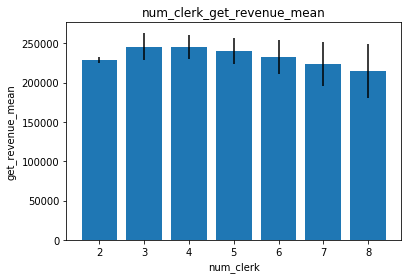

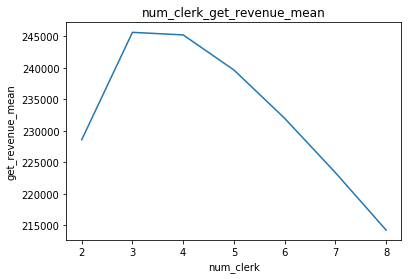

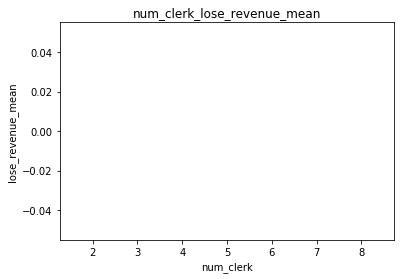

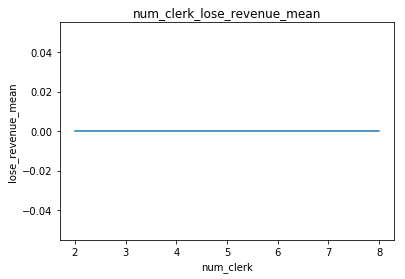

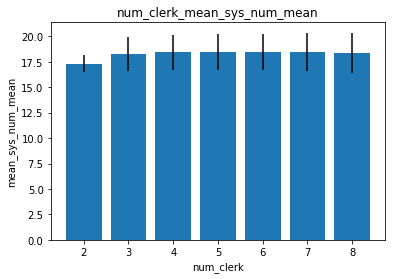

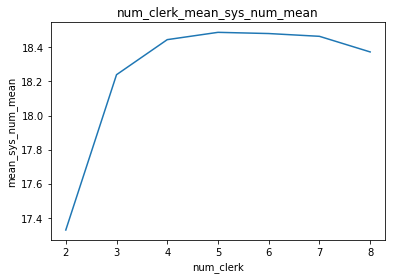

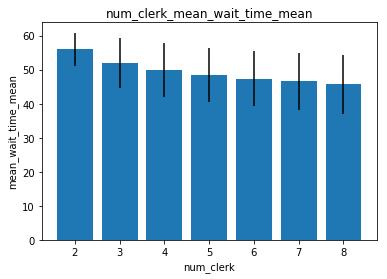

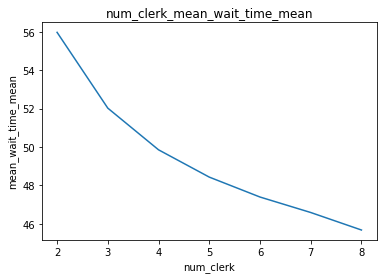

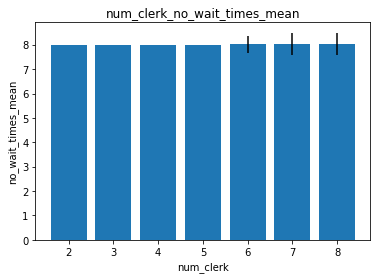

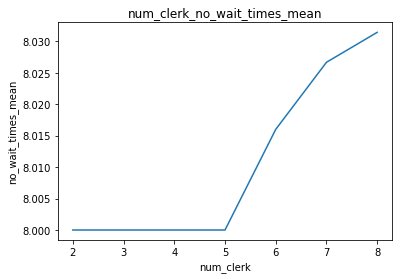

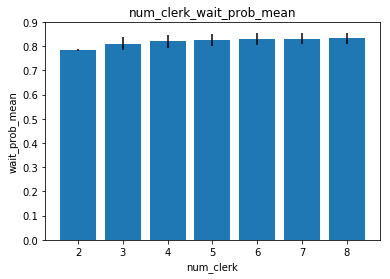

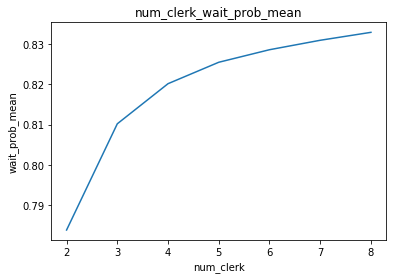

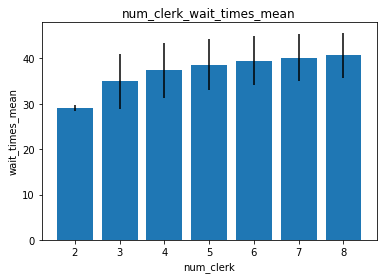

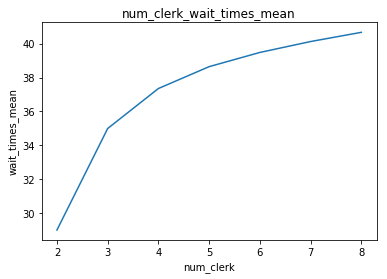

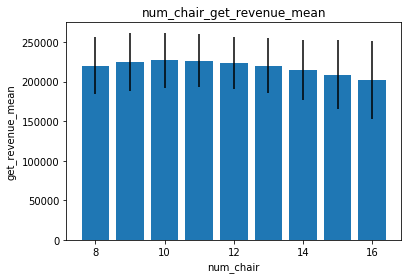

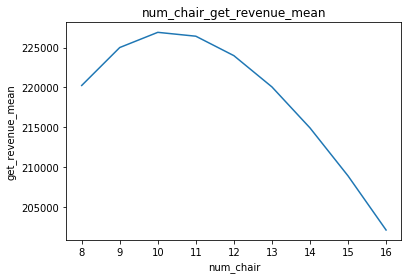

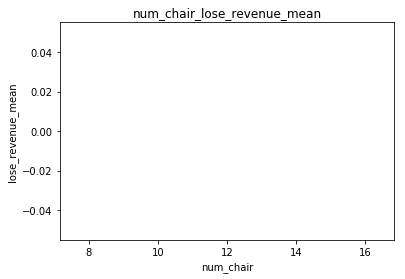

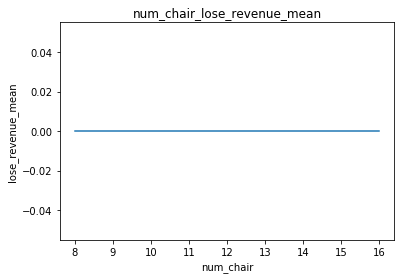

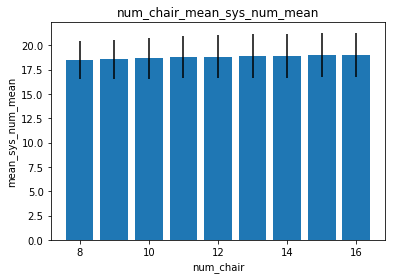

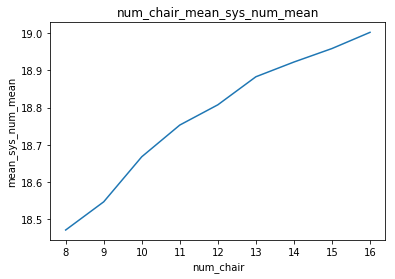

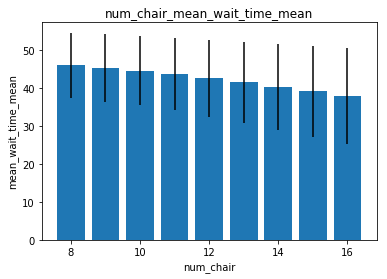

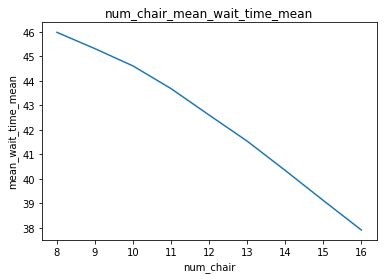

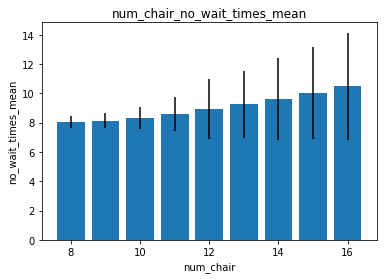

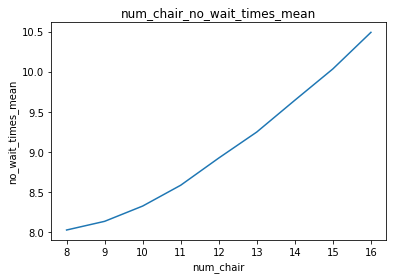

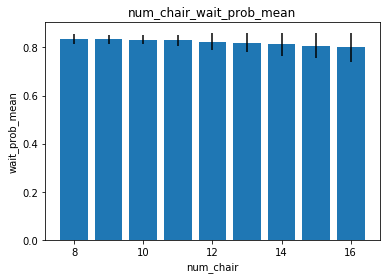

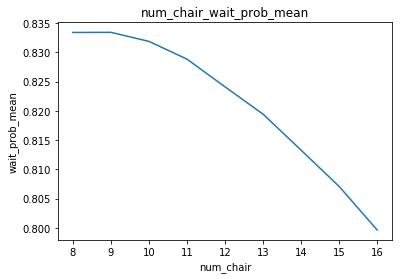

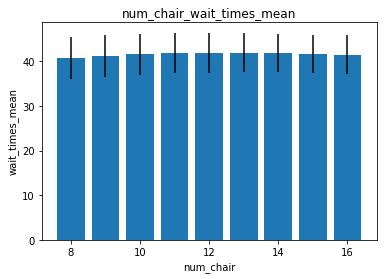

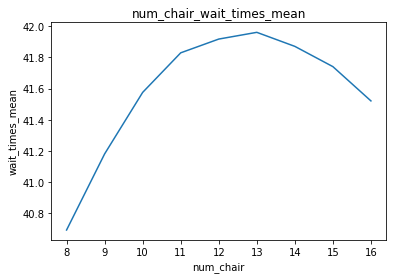

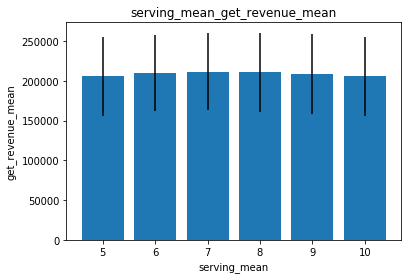

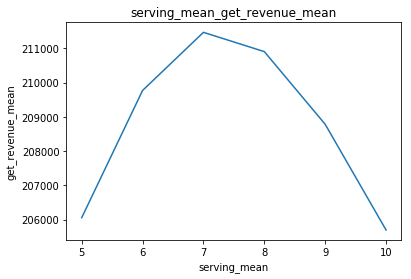

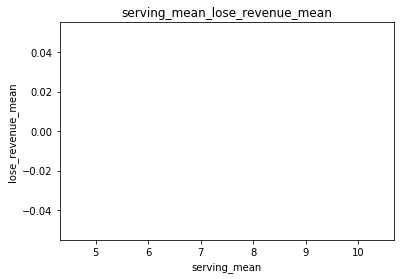

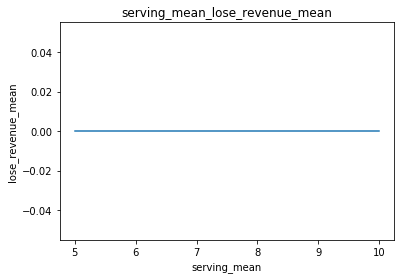

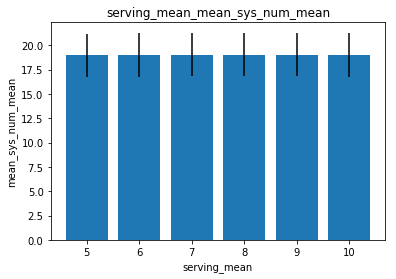

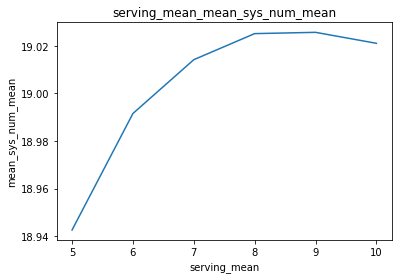

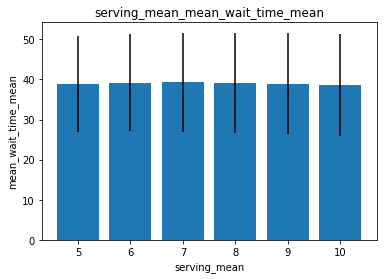

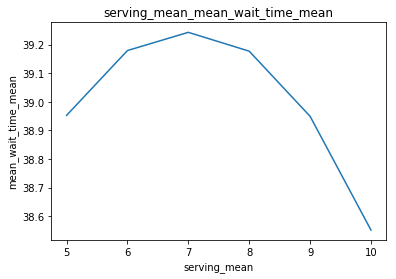

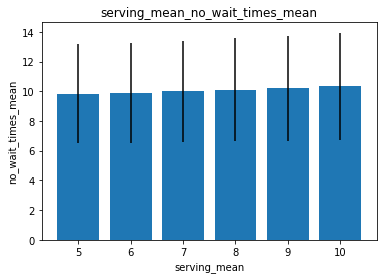

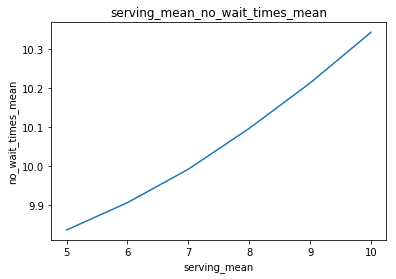

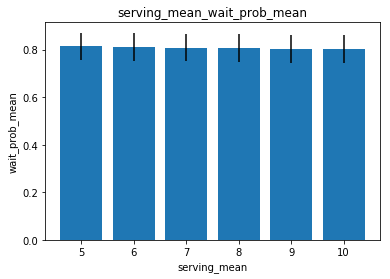

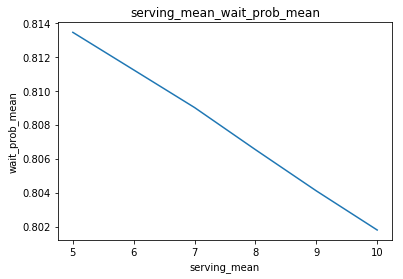

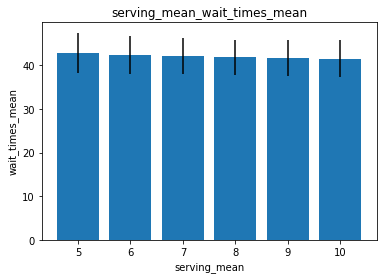

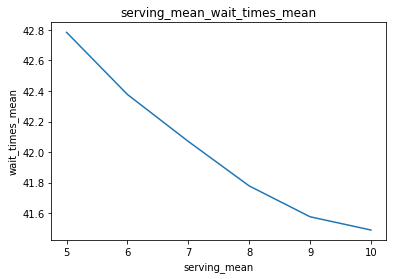

In [26]:
def show_result(data, param):
    for key in param.keys():
        print("---------showing:{}----------".format(key))
        dt = data[data.index == key]
        for col in dt.columns:
            if col.endswith("std"):
                continue
            std_col = col[:-4]+"std"
            plt.figure()
            plt.bar(param[key], dt[col], yerr=dt[std_col], align="center")
            plt.title(key+"_"+col)
            plt.xlabel(key)
            plt.ylabel(col)
#             plt.savefig(key+"_"+col+"_bar.png")
            plt.figure()
            plt.plot(param[key], dt[col])
            plt.title(key+"_"+col)
            plt.xlabel(key)
            plt.ylabel(col)
#             plt.savefig(key+"_"+col+"_plot.png")
show_result(sim_result, param)

### シミュレーション時間12時間

--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 1
eating_mean: 20


A Jupyter Widget

C:\Users\Mintei Kou\Anaconda3\lib\site-packages\ipykernel_launcher.py:320: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\Mintei Kou\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1316: UserWarning: findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


           get_revenue               lose_revenue            mean_sys_num  \
                  mean           std         mean        std         mean   
pattern                                                                     
1        243188.626087  74818.029927   220.605217  258.66371    12.308689   

                  mean_wait_time           no_wait_times           wait_prob  \
              std           mean       std          mean       std      mean   
pattern                                                                        
1        1.822135        8.21375  2.235819     20.563478  8.666197  0.707368   

                  wait_times             
              std       mean        std  
pattern                                  
1        0.152565  58.677826  40.534855  
--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget

        get_revenue                lose_revenue             mean_sys_num  \
               mean            std         mean         std         mean   
pattern                                                                    
1          277967.8  182262.368285   234.723333  263.198342    12.267786   

                  mean_wait_time           no_wait_times           wait_prob  \
              std           mean       std          mean       std      mean   
pattern                                                                        
1        1.798232       8.200201  2.195244         21.45  9.842486   0.71256   

                  wait_times            
              std       mean       std  
pattern                                 
1        0.151935  65.086667  50.52927  
--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 5
eating_mean: 20


A Jupyter Widget

        get_revenue                lose_revenue             mean_sys_num  \
               mean            std         mean         std         mean   
pattern                                                                    
1        308574.912  233240.810855     245.5168  264.030368    12.218252   

                  mean_wait_time           no_wait_times            wait_prob  \
              std           mean       std          mean        std      mean   
pattern                                                                         
1        1.781966       8.167147  2.162186         22.63  11.512798  0.715792   

                  wait_times             
              std       mean        std  
pattern                                  
1        0.150166    70.4412  56.254895  
--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 7
eating_mean: 20


A Jupyter Widget

           get_revenue               lose_revenue             mean_sys_num  \
                  mean           std         mean         std         mean   
pattern                                                                      
1        334911.846154  263974.08149   255.701538  264.586352    12.169422   

                  mean_wait_time          no_wait_times            wait_prob  \
              std           mean      std          mean        std      mean   
pattern                                                                        
1        1.767211       8.134747  2.13069     23.828462  13.004032  0.718342   

                  wait_times             
              std       mean        std  
pattern                                  
1        0.148274  75.290769  60.465274  
--------------parmetor------------
num_machine: 8
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget

           get_revenue                lose_revenue             mean_sys_num  \
                  mean            std         mean         std         mean   
pattern                                                                       
1        362397.066667  294571.830161       266.08  265.895158     12.13412   

                  mean_wait_time           no_wait_times            wait_prob  \
              std           mean       std          mean        std      mean   
pattern                                                                         
1        1.746954       8.119963  2.098113     24.549259  13.561716  0.722251   

                  wait_times             
              std       mean        std  
pattern                                  
1        0.147475  80.205185  64.660043  
--------------parmetor------------
num_machine: 10
coming_mean: 3
serving_mean: 10
num_clerk: 3
eating_mean: 20


A Jupyter Widget

KeyboardInterrupt: 

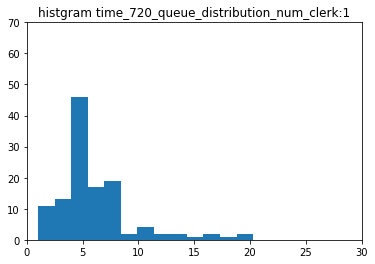

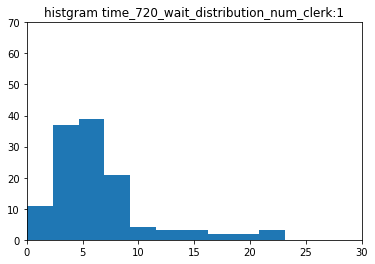

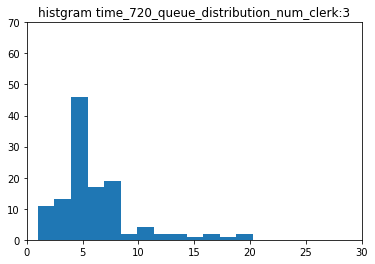

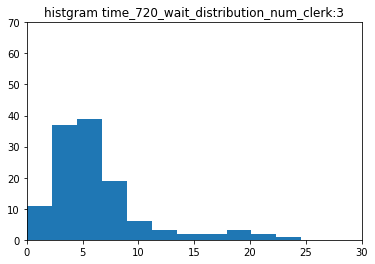

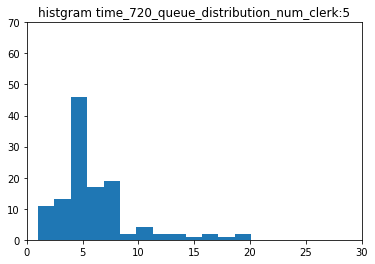

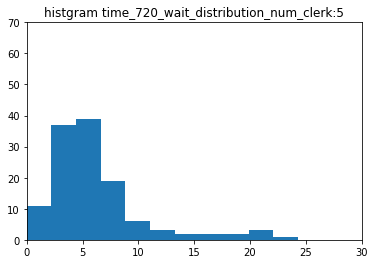

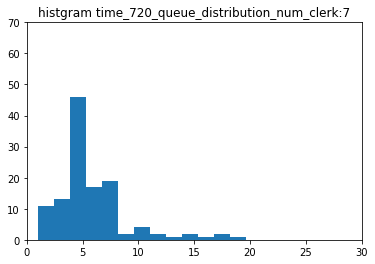

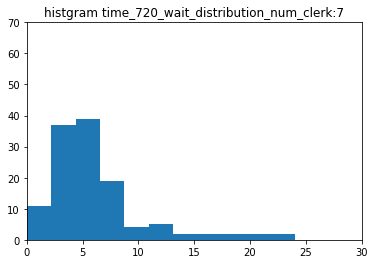

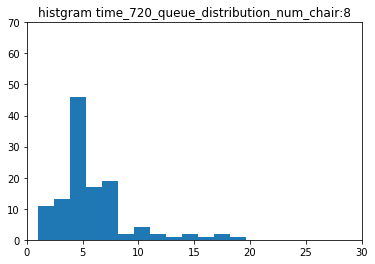

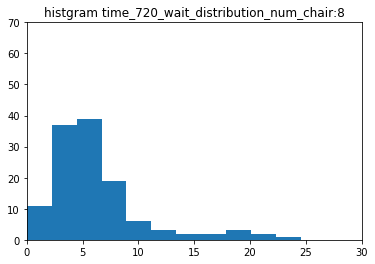

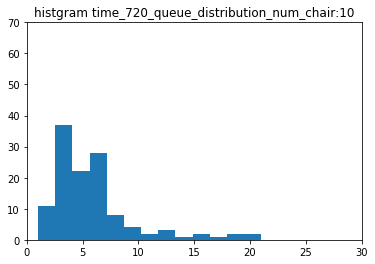

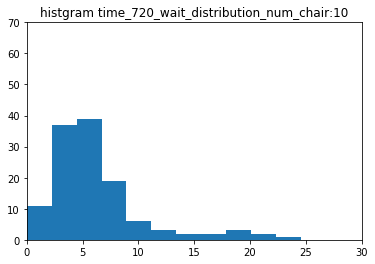

In [226]:
param = {
    "num_clerk":[1,3,5,7],
    "num_chair":[8,10,12,15],
    "serving_mean":[5,6,7,8,9,10]
}

sim_time=720


for nc in param["num_clerk"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_clerk=nc, num_machine=8, serving_mean=10, sim_time=sim_time)
    monitored_data = pd.DataFrame(monitored_data)
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_num_clerk:{}".format(sim_time, nc))
    plot_hist(wait_dist, name="time_{}_wait_distribution_num_clerk:{}".format(sim_time, nc))

    print(for_visualize)

for nc in param["num_chair"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_machine=nc, serving_mean=10, sim_time=sim_time)
    monitored_data = pd.DataFrame(monitored_data)
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_num_chair:{}".format(sim_time, nc))
    plot_hist(wait_dist, name="time_{}_wait_distribution_num_chair:{}".format(sim_time, nc))

    print(for_visualize)
    
for serve_m in param["serving_mean"]:
    monitored_data, queue_dist, wait_dist = sim_many_time(num_machine=8, serving_mean=serve_m, sim_time=sim_time)
    monitored_data = pd.DataFrame(monitored_data)
    for_visualize = monitored_data.drop("sim_num", axis=1).groupby("pattern").agg(["mean", "std"])
    plot_hist(queue_dist, name="time_{}_queue_distribution_serve_mean:{}".format(sim_time, serve_m))
    plot_hist(wait_dist, name="time_{}_wait_distribution_serve_mean:{}".format(sim_time, serve_m))

    print(for_visualize)

### ここから下は様々なパラメーターを用意して収束を見るためのもの

In [48]:
RANDOM_SEED = 1
INITIAL_MEMBER = 5
NUM_MACHINES = 8  # Number of machines in the carwash
SIM_TIME = 720     # Simulation time in minutes
COMING_MEAN = 3
EATING_MEAN = 20
EATING_SIGMA = 1
SERVING_MEAN = 8
SERVING_SIGMA = 0.1
NUM_CLERK = 3
SIM_TIME = 180

for serving_mean in range(7,13):
#     for chair_num in [8,10,12,15]:
    print("-------COME:{}----INI:{}----NC:{}------CN:{}---SM:{}-----".format(COMING_MEAN, INITIAL_MEMBER, NUM_CLERK, NUM_MACHINES, serving_mean))
    monitored_data = sim_one_time(COMING_MEAN, INITIAL_MEMBER, num_clerk=NUM_CLERK, simtime=SIM_TIME, serve_mean=serving_mean)
    print("mean_wait:", monitored_data.wait_enter.mean())
    print("mean_wait prob:", (monitored_data.wait_enter>0).mean())
    print("mean_clerk_wait:", monitored_data.wait_for_clerk.mean())
    print("mean_clerk_wait prob:", (monitored_data.wait_for_clerk>0).mean())
    print("length:", len(monitored_data))
    draw_result(monitored_data, "wait_enter", COMING_MEAN, INITIAL_MEMBER, NUM_CLERK, SERVING_MEAN)

In [45]:
RANDOM_SEED = 1
INITIAL_MEMBER = 20
NUM_MACHINES = 12  # Number of machines in the carwash
SIM_TIME = 720     # Simulation time in minutes
COMING_MEAN = 8
EATING_MEAN = 20
EATING_SIGMA = 1
SERVING_MEAN = 8
SERVING_SIGMA = 0.1
NUM_CLERK = 3
SIM_TIME = 720

for coming_mean in range(1, COMING_MEAN):
    for chair_num in [8,10,12,15]:
        print("-------COME:{}----INI:{}----NC:{}------CN:{}--------".format(coming_mean, INITIAL_MEMBER, NUM_CLERK, chair_num))
        monitored_data = sim_one_time(coming_mean, ini_num, num_clerk=NUM_CLERK, simtime=SIM_TIME)
        draw_result(monitored_data, "wait_enter", coming_mean, INITIAL_MEMBER, NUM_CLERK, chair_num)

In [46]:
RANDOM_SEED = 1
INITIAL_MEMBER = 20
NUM_MACHINES = 12  # Number of machines in the carwash
SIM_TIME = 720     # Simulation time in minutes
COMING_MEAN = 8
EATING_MEAN = 20
EATING_SIGMA = 1
SERVING_MEAN = 8
SERVING_SIGMA = 0.1
NUM_CLERK = 3
SIM_TIME = 720

for coming_mean in range(1, COMING_MEAN):
    for num_cl in [1,3,5,8,10]:
        print("-------COME:{}----INI:{}----NC:{}--------------".format(coming_mean, INITIAL_MEMBER, NUM_CLERK))
        monitored_data = sim_one_time(coming_mean, ini_num, num_clerk=num_cl, simtime=SIM_TIME)
    
        draw_result(monitored_data, "wait_enter", coming_mean, INITIAL_MEMBER, num_cl)

In [47]:
RANDOM_SEED = 1
INITIAL_MEMBER = 20
NUM_MACHINES = 12  # Number of machines in the carwash
SIM_TIME = 720     # Simulation time in minutes
COMING_MEAN = 8
EATING_MEAN = 20
EATING_SIGMA = 1
SERVING_MEAN = 8
SERVING_SIGMA = 0.1
NUM_CLERK = 3

for coming_mean in range(1, COMING_MEAN):
    for ini_num in range(1, INITIAL_MEMBER, 3):
        print("-------COME:{}----INI:{}------".format(coming_mean, ini_num))
        monitored_data = sim_one_time(coming_mean, ini_num)
    
        draw_result(monitored_data, "wait_enter", coming_mean, ini_num, NUM_CLERK)